## Final Project Submission

Please fill out:
* Student name: Zeth Abney
* Student pace: full time
* Scheduled project review date/time: 
* Instructor name: Matt Carr
* Blog post URL:


# Import packages and define functions

In [1]:
# data visualiztion
import matplotlib.pyplot as plt
import seaborn as sns

# raw data handling
import pandas as pd
import numpy as np
import datetime as dt

# regression models
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms 
from statsmodels.formula.api import ols
import scipy.stats as stats

# Feature selection
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV

# model validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score

# Variance inflation factor, mean abs/squarred error
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings # weird sns.distplot() warnings
warnings.filterwarnings("ignore")

# make stuff look cooler
plt.style.use('fivethirtyeight')

In [100]:
# creates dictionary of variance inflation factors. 
def create_vif_list(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    good_vifs = []
    bad_vifs = []

    for k,v in vif_dict.items():
        if v < 10:
            good_vifs.append(k)
        else:
            bad_vifs.append(k)

    return good_vifs,bad_vifs

def create_vif_dictionary(X):
    X = sm.add_constant(X)
    vif_dict = {}

    for i in range(len(X.columns)):
        vif = variance_inflation_factor(X.values, i)
        v = X.columns[i]
        vif_dict[v] = vif

    return vif_dict

# create a dictionary showing the adjusted R-squared values for each feature individually
def create_R2_dictionary(X,y):

    adj_R_squares = {}

    for feature in X.columns:
        predictors_int = sm.add_constant(X[feature])
        model = sm.OLS(y,predictors_int).fit()
        adj_R_square = float(model.summary2().tables[0][3][0])
        adj_R_squares[feature] = adj_R_square
        
    return adj_R_squares

# author's docstring is in a markup cell down below in the stepwise selection section
def stepwise_selection(X, y, 
                       initial_list=[], 
                       threshold_in=0.01, 
                       threshold_out = 0.05, 
                       verbose=True):
    included = list(initial_list)

    while True:
        changed=False
        # forward step
        excluded = list(set(X.columns)-set(included))
        new_pval = pd.Series(index=excluded)
        for new_column in excluded:
            model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included+[new_column]]))).fit()
            new_pval[new_column] = model.pvalues[new_column]
        best_pval = new_pval.min()
        if best_pval < threshold_in:
            best_feature = new_pval.idxmin()
            included.append(best_feature)
            changed=True
            if verbose:
                print('Add  {:30} with p-value {:.6}'.format(best_feature, best_pval))
        # backward step
        model = sm.OLS(y, sm.add_constant(pd.DataFrame(X[included]))).fit()
        # use all coefs except intercept
        pvalues = model.pvalues.iloc[1:]
        worst_pval = pvalues.max() # null if pvalues is empty
        if worst_pval > threshold_out:
            changed=True
            worst_feature = pvalues.argmax()
            worst_feature_name = included[worst_feature]
            included.pop(worst_feature)
            if verbose:
                print('Drop {:30} with p-value {:.6}'.format(worst_feature_name, worst_pval))
        if not changed:
            break
    return included

# recursive feature elimination
def run_RFE(X,y,n=1):

    linreg = LinearRegression()
    selector = RFE(linreg,n_features_to_select=n)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass
    return selections, rankers

# recuersive feature elimination with cross validation
def run_RFECV(X,y,select_rank=False):

    linreg = LinearRegression()
    selector = RFECV(linreg)
    selector = selector.fit(X, y)

    selected = selector.support_ # list of bools representing if feature is selected or not
    selections = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(selected): # append labels of selected features to selections list
        if feature == True:
            selections.append(labels[idx])
        else:
            pass
    
    ranked = selector.ranking_ # list of bools representing if feature is selected or not
    rankers = [] # list of column names that are selected
    labels = list(X.columns) # list of all column names 

    for idx,feature in enumerate(ranked): # append labels of selected features to selections list
        if feature == 1:
            rankers.append(labels[idx])
        else:
            pass

    if select_rank == True:
        return selections
    else:
        return rankers

# returns OLS linear regression model
def run_OLS_model(X,y):

    predictors_int = sm.add_constant(X)
    model = sm.OLS(y,predictors_int).fit()

    return model

# returns dictionary: keys are column labels, values are count of NaN values present
def create_NaN_dictionary(X):

    NaN_dict = {}

    for feature in X.columns:
        NaN_dict[feature] = sum(X[feature].isna())

    return NaN_dict

def create_CC_df(X,minimum=0,maximum=1):

    cor_df=X.corr().abs().stack().reset_index().sort_values(0, ascending=False)
    cor_df['pairs'] = list(zip(cor_df.level_0, cor_df.level_1))
    cor_df.set_index(['pairs'], inplace = True)
    cor_df.drop(columns=['level_1', 'level_0'], inplace = True)
    cor_df.columns = ['cc']
    cor_df.drop_duplicates(inplace=True)
    cor_df = cor_df[(cor_df.cc>minimum) & (cor_df.cc < maximum)]
    
    return cor_df

def model_strength_indicators(model):
    indicator_dict = {
    'r_squared':model.summary2().tables[0][3][0],
    'skew':model.summary2().tables[2][1][2],
    'kurtosis':model.summary2().tables[2][1][3],
    'Durbin Watson':model.summary2().tables[2][3][0],
    'Jarque-Bera':model.summary2().tables[2][3][1],
    'P value':model.summary2().tables[2][3][2],
    'Condition':model.summary2().tables[2][3][3],
    'Coef. weight': sum(model.summary2().tables[1]['Coef.'][1:])
    }
    return indicator_dict

def p_value_selection(model):
    p_values = model.summary2().tables[1]['P>|t|'][1:] # get series of all features's P values
    low_Ps = p_values.loc[p_values < .05].keys() # get the labels of the features only with P values below 0.05
    return low_Ps


# Import data and prepare for exploration
initial record count is 21597

In [3]:
data = pd.read_csv('data/kc_house_data.csv')
data.drop(data.loc[data['sqft_basement']=='?'].index,inplace=True) # remove '?' from the data.

##### Make object types numerical

In [4]:
# convert all string types into np floats
data.sqft_basement = [float(sq) for sq in list(data.sqft_basement)]


# Replaces grade strings with numerics based on data dict. 
grade_strings = list(data.grade.unique()) # list of unique values from column
grade_nums = [int(grade.split()[0]) for grade in list(data.grade.unique())] # list of corresponding integer type values

# replaces a cell value with the int of the first character of its existing string
data.grade.replace(to_replace=grade_strings,value=grade_nums,inplace=True)


# replaces condition objects with numerics based on data dict.
condition_dict = {'Poor':1,'Fair':2,'Average':3,'Good':4,'Very Good':5}
data.condition.replace(to_replace=condition_dict,inplace=True)


# replace yr_built NaNs with numeric 0
data.yr_renovated.replace(to_replace=np.nan,value=0,inplace=True)


# convert waterfront into numeric boolean
waterfront_bool_dict = {'YES':1,'NO':0,np.nan:0}
data.waterfront.replace(to_replace=waterfront_bool_dict,inplace=True)


# convert view from string into categorical ordinal
view_dict = {np.nan:0,'NONE':0,'FAIR':1,'AVERAGE':2,'GOOD':3,'EXCELLENT':4}
data.view.replace(to_replace=view_dict,inplace=True)


# convert dates into ordinals, extrapolate month from date into new column. 
data.date = pd.to_datetime(data['date']) # convert date string into datetime object 
data['sale_month'] = data.date.apply(lambda x: x.month) # extropolate month from date into new column
data.date = data['date'].map(dt.datetime.toordinal) # convert original date to ordinal
data.rename({'date':'sale_date'},axis=1,inplace=True) # rename date to 'sale_date' for readability 

In [5]:
# inspect data for any object types 
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21143 entries, 0 to 21596
Data columns (total 22 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21143 non-null  int64  
 1   sale_date      21143 non-null  int64  
 2   price          21143 non-null  float64
 3   bedrooms       21143 non-null  int64  
 4   bathrooms      21143 non-null  float64
 5   sqft_living    21143 non-null  int64  
 6   sqft_lot       21143 non-null  int64  
 7   floors         21143 non-null  float64
 8   waterfront     21143 non-null  int64  
 9   view           21143 non-null  int64  
 10  condition      21143 non-null  int64  
 11  grade          21143 non-null  int64  
 12  sqft_above     21143 non-null  int64  
 13  sqft_basement  21143 non-null  float64
 14  yr_built       21143 non-null  int64  
 15  yr_renovated   21143 non-null  float64
 16  zipcode        21143 non-null  int64  
 17  lat            21143 non-null  float64
 18  long  

In [6]:
# declare target and predictor variables
y = data.price 
X = data.drop('price',axis=1)

# Create and visualize a baseline

#### First round of feature selection and elimination
- First select features based on P values using a forward-backward stepwise selection. 
- Then perform feature ranking with recursive feature elimination with cross validation.
- Finally eliminate highly colinear features based on variance inflation factor and correlation coefficients.

In [7]:
# stepwise feature elmination
stepwise_selected = stepwise_selection(X,y,verbose=False)
X_base = X[stepwise_selected]

In [8]:
# recursive feature elimination
RFE_selection = run_RFECV(X_base,y)
X_base = X_base[RFE_selection]

In [9]:
# inspecting multicolinearity 

# eliminate features base on variance inflation factor
good,bad = create_vif_list(X_base)
X_base = X_base[good[1:]]


In [10]:
# not eliminating sqft_lot or sqft_lot15because the correlation coefficient is less than .75, I suspect at least one will be weeded out later on anyway. 
cc_df = create_CC_df(X_base,.6,1)
cc_df

,cc
pairs,
"(grade, sqft_living15)",0.713574
"(grade, bathrooms)",0.666493


In [11]:
base_model = run_OLS_model(X_base,y)
base_model_strength = model_strength_indicators(base_model)

In [12]:
# eliminate any remaining features with P values above 0.05
Ps = p_value_selection(base_model)
X_base = X_base[Ps]
base_model = run_OLS_model(X_base,y)
base_resid = base_model.resid

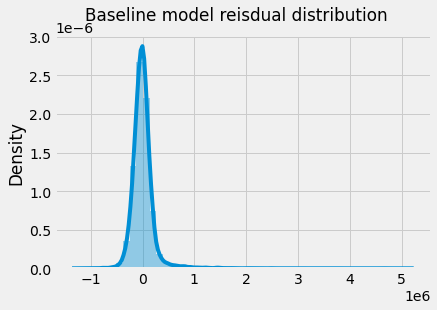

In [13]:
sns.distplot(base_resid)
plt.suptitle("Baseline model reisdual distribution")
plt.show()

In [14]:
base_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.665
Model:                            OLS   Adj. R-squared:                  0.664
Method:                 Least Squares   F-statistic:                     2991.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:24:50   Log-Likelihood:            -2.8942e+05
No. Observations:               21143   AIC:                         5.789e+05
Df Residuals:                   21128   BIC:                         5.790e+05
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -6.89e+07   1.07e+07     -6.458      0.000   -8.98e+07    -4.8e+07
grade          1.417e+05   2088.929     67.822      0.000    1.38e+05    1.46e+05
yr_built      -3175.1151     72.921    -43.542      0.000   -3318.045   -3032.185
lat            5.772e+05   1.14e+04     50.837      0.000    5.55e+05    5.99e+05
waterfront     6.668e+05   1.94e+04     34.324      0.000    6.29e+05    7.05e+05
view           5.775e+04   2230.003     25.898      0.000    5.34e+04    6.21e+04
bathrooms      1.084e+05   2792.894     38.828      0.000    1.03e+05    1.14e+05
zipcode        -508.9467     35.096    -14.502      0.000    -577.738    -440.156
long          -1.605e+05   1.35e+04    -11.856      0.000   -1.87e+05   -1.34e+05
condition      2.682e+04   2490.705     10.769      0.000    2.19e+04    3.17e+04
sale_date       104.6278     13.859      7.549      0.000      77.462     131.793
yr_renovated     24.7782      4.264      5.811      0.000      16.420      33.137
sqft_living15    88.6894      3.331     26.627      0.000      82.161      95.218
sale_month    -1524.3403    501.924     -3.037      0.002   -2508.149    -540.532
id            -1.737e-06    5.1e-07     -3.403      0.001   -2.74e-06   -7.36e-07
==============================================================================
Omnibus:                    20776.283   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          3500142.415
Skew:                           4.384   Prob(JB):                         0.00
Kurtosis:                      65.420   Cond. No.                     3.94e+13
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.94e+13. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

##### Observations:

Data is clearly not normally distributed. First step is to investigate impact of elimating outliers which I am considering any record where the target variable is greater than 3 standard deviations from its the target variable mean.

In [15]:
std_thresh = data.price.std()*3 # three standard deviations 
std_cap = data.loc[abs(data['price']) <= std_thresh] # slicing all data within the defined range

#re-declare X and y variables
y = std_cap.price
X_outliers = std_cap[X_base.columns]

Inspect resulting model 

In [16]:
# build model and grab residuals
outlier_model = run_OLS_model(X_outliers,y)
Ps = p_value_selection(outlier_model)
X_outliers = X_outliers[Ps]

outlier_model = run_OLS_model(X_outliers,y)
outlier_model_strength = model_strength_indicators(outlier_model)
outlier_model_residual = outlier_model.resid


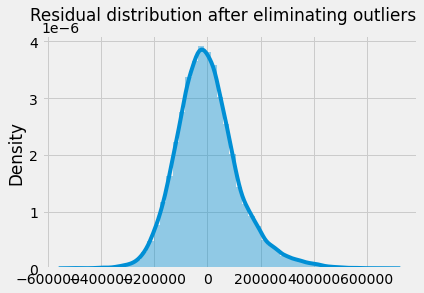

In [17]:
# visualize model residuals
sns.distplot(outlier_model_residual)
plt.suptitle('Residual distribution after eliminating outliers')
plt.show()

In [18]:
outlier_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                     3199.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:24:50   Log-Likelihood:            -2.6167e+05
No. Observations:               19982   AIC:                         5.234e+05
Df Residuals:                   19968   BIC:                         5.235e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -5.787e+07   6.07e+06     -9.527      0.000   -6.98e+07    -4.6e+07
grade           9.06e+04   1251.003     72.423      0.000    8.81e+04    9.31e+04
yr_built      -1880.1207     42.575    -44.160      0.000   -1963.571   -1796.670
lat            5.366e+05   6338.153     84.666      0.000    5.24e+05    5.49e+05
waterfront     1.355e+05   1.74e+04      7.787      0.000    1.01e+05     1.7e+05
view           3.132e+04   1424.922     21.978      0.000    2.85e+04    3.41e+04
bathrooms       5.84e+04   1652.273     35.342      0.000    5.52e+04    6.16e+04
zipcode        -162.4890     20.016     -8.118      0.000    -201.722    -123.256
long          -1.973e+04   7633.570     -2.585      0.010   -3.47e+04   -4768.921
condition       2.59e+04   1417.710     18.272      0.000    2.31e+04    2.87e+04
sale_date        66.6480      7.890      8.447      0.000      51.182      82.114
yr_renovated     18.9128      2.553      7.408      0.000      13.909      23.917
sqft_living15    76.7769      2.004     38.318      0.000      72.850      80.704
sale_month    -1288.9726    285.065     -4.522      0.000   -1847.724    -730.221
==============================================================================
Omnibus:                     1628.633   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2711.445
Skew:                           0.610   Prob(JB):                         0.00
Kurtosis:                       4.329   Cond. No.                     5.41e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: 
- Indicators of normality slightly improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high
- some signs of multi-colinearity

Next step is to investigate the impact of log transforming the target variable

In [19]:
# create log transformed target variable
y_log = np.log(y)

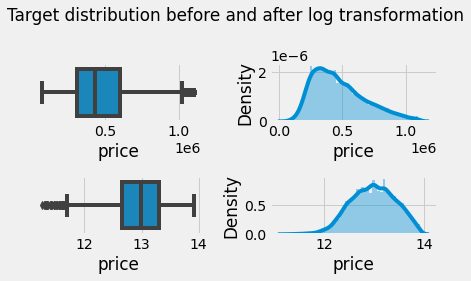

In [20]:
fig,axes = plt.subplots(2,2)

sns.boxplot(y,ax=axes[0,0]) # boxplot before
sns.distplot(y,ax=axes[0,1]) # distplot before

sns.boxplot(y_log,ax=axes[1,0]) # boxplot after
sns.distplot(y_log,ax=axes[1,1]) # boxplot after

fig.suptitle("Target distribution before and after log transformation")
plt.tight_layout()
plt.show()

In [21]:
stepwise_selected = stepwise_selection(X_outliers,y_log,verbose=False)
X_for_log = X_outliers[stepwise_selected]

RFE_selection = run_RFECV(X_for_log,y_log)
X_for_log = X_for_log[RFE_selection]

good,bad = create_vif_list(X_for_log)
X_for_log = X_for_log[good]

log_model = run_OLS_model(X_for_log,y_log)
Ps = p_value_selection(log_model)
X_for_log = X_for_log[Ps]

log_model = run_OLS_model(X_for_log,y_log)
log_model_strength = model_strength_indicators(log_model)
log_model_residuals = log_model.resid

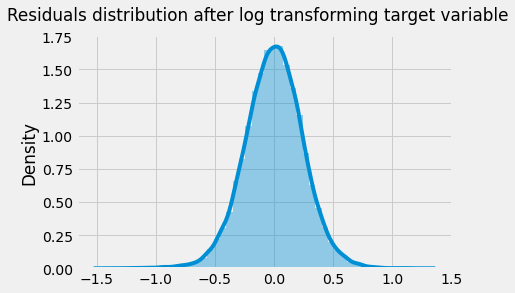

In [22]:
# visualize model residuals
sns.distplot(log_model_residuals)
plt.suptitle('Residuals distribution after log transforming target variable')
plt.show()

In [23]:
log_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.690
Model:                            OLS   Adj. R-squared:                  0.690
Method:                 Least Squares   F-statistic:                     3708.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:24:55   Log-Likelihood:                -423.68
No. Observations:               19982   AIC:                             873.4
Df Residuals:                   19969   BIC:                             976.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -135.1182     12.750    -10.598      0.000    -160.109    -110.128
grade             0.1815      0.003     69.540      0.000       0.176       0.187
yr_built         -0.0034   8.71e-05    -39.107      0.000      -0.004      -0.003
lat               1.3525      0.013    101.733      0.000       1.326       1.379
sqft_living15     0.0001   4.08e-06     36.164      0.000       0.000       0.000
bathrooms         0.1376      0.003     39.694      0.000       0.131       0.144
view              0.0599      0.003     20.053      0.000       0.054       0.066
condition         0.0612      0.003     20.559      0.000       0.055       0.067
sale_date         0.0002   1.66e-05      9.719      0.000       0.000       0.000
waterfront        0.3159      0.037      8.649      0.000       0.244       0.387
zipcode          -0.0003   3.76e-05     -8.140      0.000      -0.000      -0.000
yr_renovated   3.635e-05   5.35e-06      6.788      0.000    2.59e-05    4.68e-05
sale_month       -0.0025      0.001     -4.112      0.000      -0.004      -0.001
==============================================================================
Omnibus:                      303.884   Durbin-Watson:                   1.975
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              531.852
Skew:                          -0.107   Prob(JB):                    3.23e-116
Kurtosis:                       3.770   Cond. No.                     5.41e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.41e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Observations: 
- Indicators of normality improved but still needs work.
- skew is close to zero, kurtosis is slightly heavy
- r-squared has improved
- jarque-bera is fairly high, but significantly better
- condition number is unchanged

Next step is another round of new feature engineering

# Engineering new features to further improve the model

- First new features will be engineered by joining IRS data on income by zipcode.
- two categorical variables will be one-hot encoded (waterfront location, and tax bracket)  
- Lastly, new feature may be developed by interpolating existing feature of data. 

Features extrapolated from zipcode

In [24]:
# Dictionary with zipcodes associated with waterfronts described by the data dictionary
water_loc_dict = {'Duwamish':[98168],
'Elliott Bay':[98119,98104,98129,98132,98127,98125,98195,98101,98134,98170,98139,98131,98181], 
'Puget Sound':[98071,98083,98013,98070,98031,98131,98063,98195,98207,98190], 
'Lake Union':[98109], 
'Ship Canal':[00000], 
'Lake Washington':[98072,98077], 
'Lake Sammamish':[98074,98075,98029], 
'other lake':[00000], 
'river/slough waterfronts':[00000]}

# list to contain new column data
waterfront_list = []

# for loop to assign waterfront based on zipcode
for zipcode in X_outliers.zipcode:
    for k,v in water_loc_dict.items():
        if zipcode in v:
            waterfront_list.append(k)
            appended = True
            break
        else: 
            appended = False
    if not appended:
        waterfront_list.append('NONE')

# print(len(waterfront_list),set(waterfront_list))
X_outliers['waterfront_loc'] = waterfront_list
X_for_log['waterfront_loc'] = waterfront_list

features interpolated from external data

In [25]:
# IRS income tax data from data.world 
# https://data.world/jonloyens/irs-income-by-zip-code/workspace/query?queryid=0491f7ff-f7e5-49be-ad8c-8047d6a54c57

income = pd.read_csv('data/irs_income_by_zipcode.csv')

income.avg_taxable_income = income.avg_taxable_income*1000 # scaling data back to dollar units (was in thousands)
income.taxable_income_amount = income.taxable_income_amount*1000 
income.rename({'taxable_income_amount':'zip_tax_revenue'},axis=1,inplace=True) # renaming to something more idiomatic

# # create lists to stage data in order to concat new columns later
joint_filing_bracket = [] #for the joint filing tax schedule

# there is probably a more "pythony" way to do this for loop but it works so I'm not touching it 
for average in income.avg_taxable_income:
    if average > 628301:
        joint_filing_bracket.append(7)
    elif average <= 19900:
        joint_filing_bracket.append(1)
    elif (average >= 19901) and (average <= 81050):
        joint_filing_bracket.append(2)
    elif (average >= 81051) and (average <= 172750):
        joint_filing_bracket.append(3)
    elif (average >= 172751) and (average <= 329850):
        joint_filing_bracket.append(4)
    elif (average >= 329851) and (average <= 418850):
        joint_filing_bracket.append(5)
    elif (average >= 418851) and (average <= 628300):
        joint_filing_bracket.append(6)

# assign discovered data to new column
income['joint_filing_tax_bracket'] = joint_filing_bracket

# create dictionary of zipcodes with corresponding tax bracket
# dictionary will be used to assign create similar columns in the principal data.
joint_filing_tax_dict = {}
tax_revenue_dict = {}

# create ditionaries to later assign values to principal data
for row in income.iterrows():
    joint_filing_tax_dict[row[1][0]] = row[1][3]
    tax_revenue_dict[row[1][0]] = row[1][1]

# concat columns to X containing tax bracket based on single and joint filing federal income tax schedule
X_outliers['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_outliers['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)

X_for_log['income_tax_bracket'] = X.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_for_log['zip_tax_revenue'] = X.zipcode.replace(to_replace=tax_revenue_dict)


In [26]:
# create dummy variables
waterfront_dummies = pd.get_dummies(X_outliers.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)
bracket_dummies = pd.get_dummies(X_outliers.income_tax_bracket,drop_first=True,prefix='income_tax',prefix_sep='_')
sale_month_dummies = pd.get_dummies(X_outliers.sale_month,prefix='sale_month',prefix_sep='_',drop_first=True)

# reasign X to concatenated dataframe, dropping features no longer needed
X_outliers = X_outliers.drop(['waterfront_loc','zipcode'],axis=1)
X_outliers = pd.concat([X_outliers,bracket_dummies,waterfront_dummies,sale_month_dummies],axis=1)

X_for_log = X_for_log.drop(['waterfront_loc','zipcode'],axis=1)
X_for_log = pd.concat([X_for_log,bracket_dummies,waterfront_dummies,sale_month_dummies],axis=1)

### create baseline for engineered features

In [27]:
pre_hot_base = run_OLS_model(X_outliers,y) # some high p values
Ps = p_value_selection(pre_hot_base)
X_hot = X_outliers[Ps] 
hot_base_model = run_OLS_model(X_hot,y)
hot_base_model_stregnth = model_strength_indicators(hot_base_model)
hot_base_model_residuals = hot_base_model.resid

X_hot_log = X_for_log
hot_log_model = run_OLS_model(X_for_log,y_log)
hot_log_model_stregnth = model_strength_indicators(hot_log_model)
hot_log_model_residuals = hot_log_model.resid


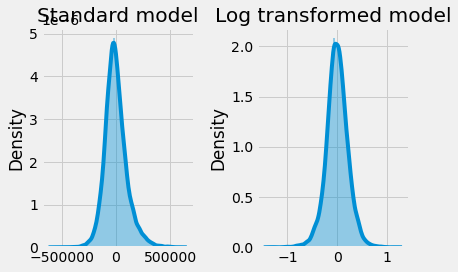

In [28]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(hot_base_model_residuals,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(hot_log_model_residuals,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

Continue to rank, select and eliminate features. 

In [29]:
# for the non-transformed model
stepwise_selections = stepwise_selection(X_hot,y,verbose=False)
X_hot = X_hot[stepwise_selections]

rfecv_selections = run_RFECV(X_hot,y)
X_hot = X_hot[rfecv_selections]

good,bad = create_vif_list(X_hot)
X_hot = X_hot[good[1:]]

In [30]:
# for the log transformed model
stepwise_selections = stepwise_selection(X_hot_log,y_log,verbose=False)
X_hot_log = X_hot_log[stepwise_selections]

rfecv_selections = run_RFECV(X_hot_log,y_log)
X_hot_log = X_hot_log[rfecv_selections]

good,bad = create_vif_list(X_hot_log)
X_hot_log = X_hot_log[good[1:]]

In [31]:
hot_base_model_filtered = run_OLS_model(X_hot,y_log)
hot_base_model_filtered_strength = model_strength_indicators(hot_base_model_filtered)
hot_base_model_filtered_resid = hot_base_model_filtered.resid

hot_log_model_filtered = run_OLS_model(X_hot_log,y_log)
hot_log_model_filtered_strength = model_strength_indicators(hot_log_model_filtered)
hot_log_model_filtered_resid = hot_log_model_filtered.resid


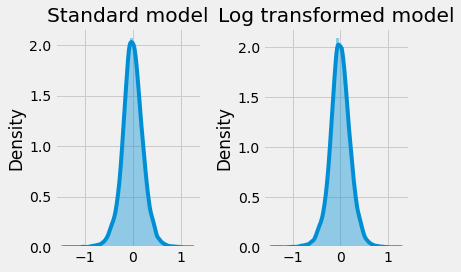

In [32]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(hot_base_model_filtered_resid,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(hot_log_model_filtered_resid,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

Continue eliminating features manually to address remaining multi-colinearity and further fit the model 

In [33]:
vif_dict = create_vif_dictionary(X_outliers)
low_vifs = [k for k,v in vif_dict.items() if v < 2.5][1:]
X_new = X_outliers[low_vifs]

# deal with resulting high p values 
new_base_model = run_OLS_model(X_new,y)
Ps = p_value_selection(new_base_model)
X_new = X_new[Ps]

# finalize model
new_base_model = run_OLS_model(X_new,y)
new_base_model_strength = model_strength_indicators(new_base_model)
new_base_model_residuals = new_base_model.resid

In [34]:
vif_dict = create_vif_dictionary(X_hot_log)
low_vifs = [k for k,v in vif_dict.items() if v < 2.5][1:]
X_new_log = X_hot_log[low_vifs]

# deal with resulting high p values 
new_log_model = run_OLS_model(X_new_log,y_log)
Ps = p_value_selection(new_log_model)
X_new_log = X_new_log[Ps]

# finalize model
new_log_model = run_OLS_model(X_new_log,y_log)
new_log_model_strength = model_strength_indicators(new_log_model)
new_log_model_residuals = new_base_model.resid

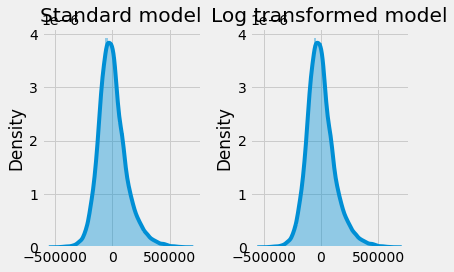

In [35]:
fig, axes = plt.subplots(1,2)
hb = sns.distplot(new_base_model_residuals,ax=axes[0]).set_title('Standard model')
hl = sns.distplot(new_log_model_residuals,ax=axes[1]).set_title('Log transformed model')

fig.tight_layout()
plt.show()

# Review model performance across iterations
Features are ranked, selected and eliminated through each iteration using the same selection pattern: first selection and elimination based on p-value using a forward-backward stepwise selection method, second selction and elimination based on feature "importance" using recursive feature elimination with cross validation. third selection and elimination based on multi-colinearity determined first by variance inflation factor and second using colinearity coefficients.

Baseline model strength after firs round of feature selection and elimination

In [36]:
simple_strengths_list = [base_model_strength,outlier_model_strength,log_model_strength] # models before new feature engineering
simple_strengths_ticks = ['base_model','outlier_model','log_model']
simple_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in simple_strengths_list],
'skews':[float(strength['skew']) for strength in simple_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in simple_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in simple_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in simple_strengths_list],
'P values':[float(strength['P value']) for strength in simple_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in simple_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in simple_strengths_list]
}

clever_strengths_list = [hot_base_model_filtered_strength,hot_base_model_filtered_strength,new_base_model_strength]
clever_strengths_ticks =['hot_model','hot_model_filtered','new_model']
clever_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in clever_strengths_list],
'skews':[float(strength['skew']) for strength in clever_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in clever_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in clever_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in clever_strengths_list],
'P values':[float(strength['P value']) for strength in clever_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in clever_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in clever_strengths_list]
}

clever_log_strengths_list = [hot_log_model_filtered_strength,hot_log_model_filtered_strength,new_log_model_strength]
clever_log_ticks = ['hot_log_model','hot_log_model_filtered','new_log_model']
clever_log_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in clever_log_strengths_list],
'skews':[float(strength['skew']) for strength in clever_log_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in clever_log_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in clever_log_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in clever_log_strengths_list],
'P values':[float(strength['P value']) for strength in clever_log_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in clever_log_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in clever_log_strengths_list]
}


all_base_strenghts_list = [base_model_strength,outlier_model_strength,log_model_strength,hot_base_model_filtered_strength,hot_base_model_filtered_strength,new_base_model_strength]
all_base_strengths_ticks = simple_strengths_ticks + clever_strengths_ticks
all_base_strenghts_dict ={
'r_squares':[float(strength['r_squared']) for strength in all_base_strenghts_list],
'skews':[float(strength['skew']) for strength in all_base_strenghts_list],
'kurtoses':[float(strength['kurtosis']) for strength in all_base_strenghts_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in all_base_strenghts_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in all_base_strenghts_list],
'P values':[float(strength['P value']) for strength in all_base_strenghts_list],
'Condition numbers':[int(strength['Condition']) for strength in all_base_strenghts_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in all_base_strenghts_list]
}

base_plus_log_list = [base_model_strength,outlier_model_strength,log_model_strength,hot_log_model_filtered_strength,hot_log_model_filtered_strength,new_log_model_strength]
base_plus_log_ticks = simple_strengths_ticks + clever_log_ticks
base_plus_log_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in base_plus_log_list],
'skews':[float(strength['skew']) for strength in base_plus_log_list],
'kurtoses':[float(strength['kurtosis']) for strength in base_plus_log_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in base_plus_log_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in base_plus_log_list],
'P values':[float(strength['P value']) for strength in base_plus_log_list],
'Condition numbers':[int(strength['Condition']) for strength in base_plus_log_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in base_plus_log_list]
}


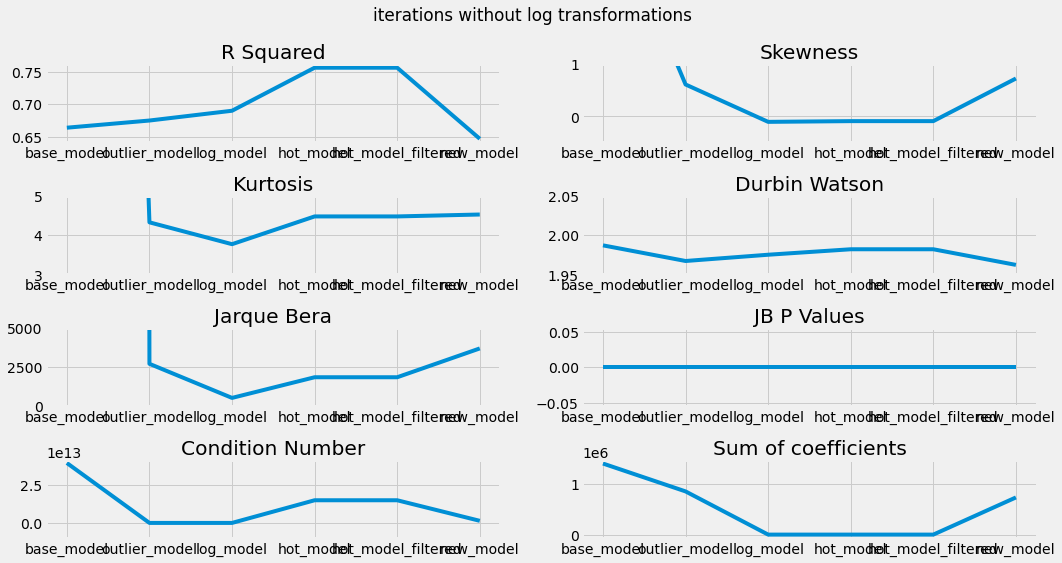

In [37]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=all_base_strengths_ticks,y=all_base_strenghts_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('iterations without log transformations')
fig.tight_layout()
plt.show()

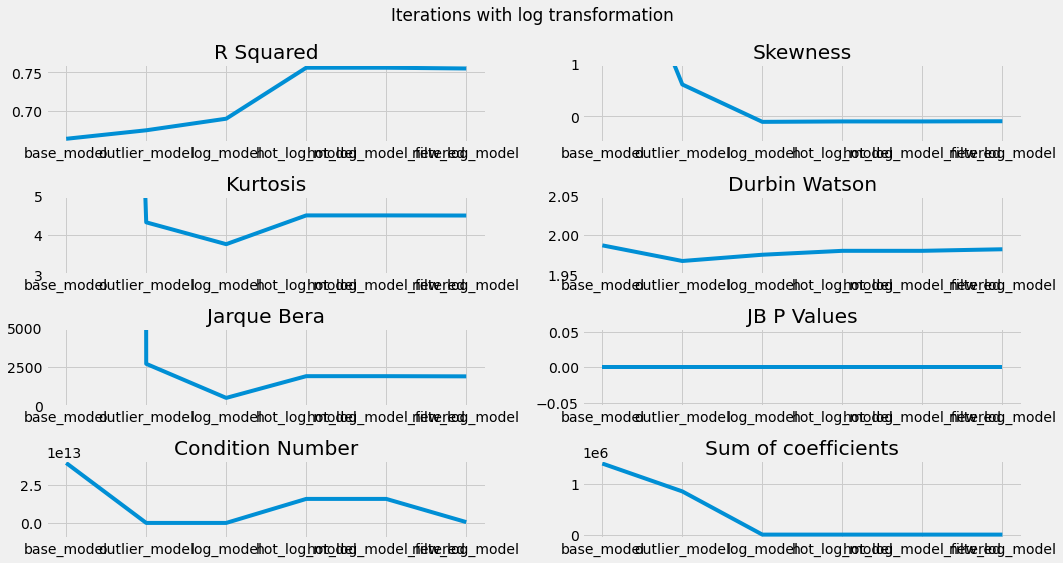

In [38]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=base_plus_log_ticks,y=base_plus_log_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('Iterations with log transformation')
fig.tight_layout()
plt.show()

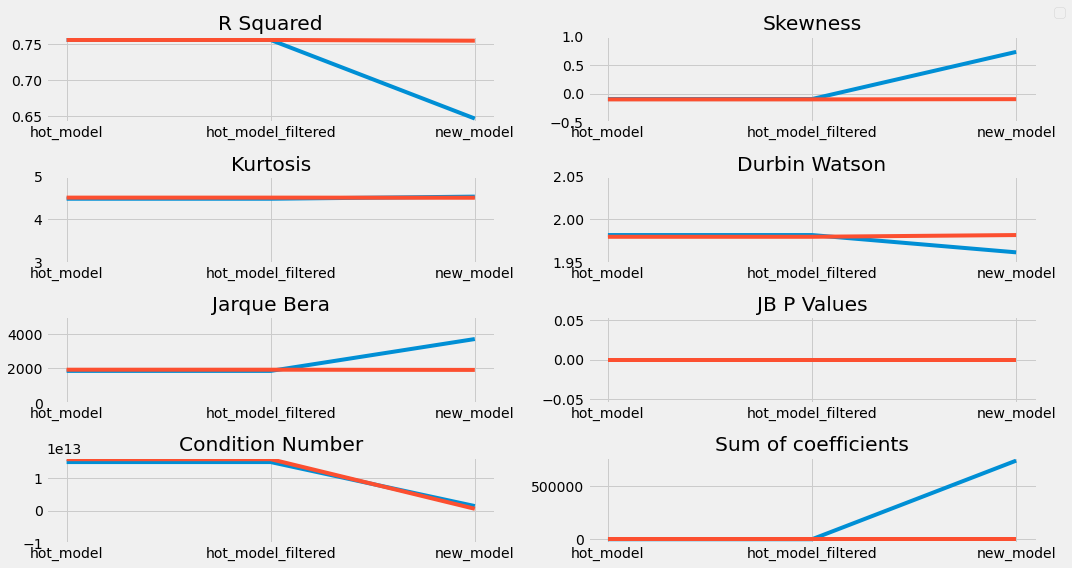

In [39]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
r_sq_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')

sk = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
sk_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)

kt = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
kt_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)

db = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
db_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)

jb = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
jb_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)

pv = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
pv_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')

cn = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
cn_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
axes[3,0].set_ylim(-10000000000000)

cf = sns.lineplot(x=clever_strengths_ticks,y=clever_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
cf_l = sns.lineplot(x=clever_strengths_ticks,y=clever_log_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
fig.legend((r_sq,r_sq_l),('Not transformed','log transformed'))
plt.show()

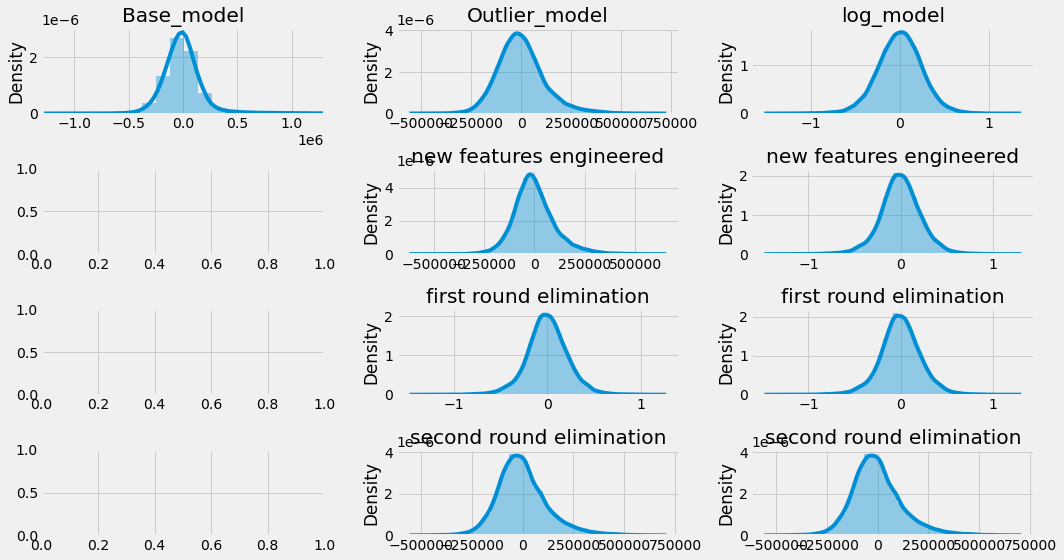

In [40]:
fig, axes = plt.subplots(4,3)

bs = sns.distplot(base_resid,ax=axes[0,0]).set_title('Base_model')
axes[0,0].set_xlim(-1300000,1300000)

ot = sns.distplot(outlier_model_residual,ax=axes[0,1]).set_title('Outlier_model')

lm = sns.distplot(log_model_residuals,ax=axes[0,2]).set_title("log_model")

bl = sns.distplot(hot_base_model_residuals,ax=axes[1,1]).set_title('new features engineered')
bl_l = sns.distplot(hot_log_model_residuals,ax=axes[1,2]).set_title('new features engineered')
# axes[1,0].set_xlim(-50000,50000)

lm = sns.distplot(hot_base_model_filtered_resid,ax=axes[2,1]).set_title('first round elimination')
lm_l = sns.distplot(hot_log_model_filtered_resid,ax=axes[2,2]).set_title('first round elimination')

hm = sns.distplot(new_base_model_residuals,ax=axes[3,1]).set_title('second round elimination')
hm_l = sns.distplot(new_log_model_residuals,ax=axes[3,2]).set_title('second round elimination')


plt.gcf().set_size_inches(15, 8)
fig.tight_layout()
plt.show()

Due to the size of the data set, in this instance the Q-Q plot is not a very useful tool for determining how well the model satisfies the assumption of normality, however the figure below does clearly show how the log transformation on the target variable significantly improved the model at the begining of the iterative process

# Model validation

In [41]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X_for_log, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

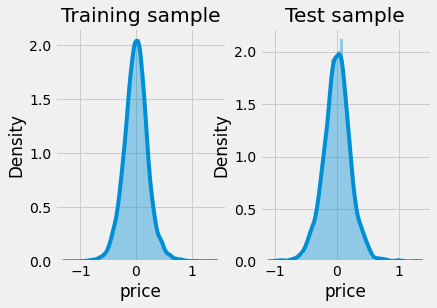

<Figure size 1440x1440 with 0 Axes>

In [42]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

plt.figure(figsize=(20,20))
plt.show()


In [43]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.048
Test Mean Squarred Error: 0.05
Difference:  0.002


In [44]:
cv_5_results  = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))


Five k-fold MSE:  -0.049
Ten k-fold MSE:  -0.049
Twenty k-fold MSE:  -0.048


#### observations on model validation
The mean squared error (MSE), a statistic representing the amount of error in a the model (i.e. how well the regression line fits the data), is calculated to be roughly the same using both a simple train-test split and the k-fold cross validation technique. The MSE is close to zero indicating the model fits the data well, and the model probably fits the real population data also. 

# Observations

After much iteration and of feature engineering, selection and transformation. The strongest model appears to be the strongest model, and the train-test sampling gives me confidence that this iteration of the model fits the population data fairly well in addition to the sample we have available here. I suspected the model would be strengthened by extrapolating certain features into new features (e.g. one hot encoding, joining tax data from a compatible data set) however that was not the case, the problem is that the zipcode feature is essentially un-interpretable due to the fact that it is both categorical and nominal. 

The next steps will be to investigate more granularly how zipcode may be extrapolaed to strengthen the model, and as a lost resort zipcode itself will simply be one-hot encoded. 

In [45]:
# log_model.summary()

### Exploring assigning and one-hot encoding only waterfront locations 

In [46]:
finalist_labels = log_model.summary2().tables[1]['t'].keys()[1:]
X_finals = std_cap.drop('price',axis=1)
X_waters = X_finals[finalist_labels]
X_taxes = X_finals[finalist_labels]

In [47]:
zipcode_dummies = pd.get_dummies(X_finals.zipcode,prefix='zipcode',prefix_sep='_',drop_first=True)

In [48]:
water_model = run_OLS_model(X_waters.drop('zipcode',axis=1),y_log)
water_model_strength = model_strength_indicators(water_model)
water_model_residuals= water_model.resid

water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.689
Method:                 Least Squares   F-statistic:                     4026.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:25:44   Log-Likelihood:                -456.78
No. Observations:               19982   AIC:                             937.6
Df Residuals:                   19970   BIC:                             1032.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const          -164.7196     12.240    -13.457      0.000    -188.711    -140.728
grade             0.1803      0.003     69.076      0.000       0.175       0.185
yr_built         -0.0032   8.48e-05    -38.206      0.000      -0.003      -0.003
lat               1.3257      0.013    102.771      0.000       1.300       1.351
sqft_living15     0.0002   3.97e-06     39.059      0.000       0.000       0.000
bathrooms         0.1368      0.003     39.415      0.000       0.130       0.144
view              0.0566      0.003     19.089      0.000       0.051       0.062
condition         0.0645      0.003     21.823      0.000       0.059       0.070
sale_date         0.0002   1.66e-05      9.743      0.000       0.000       0.000
waterfront        0.3119      0.037      8.526      0.000       0.240       0.384
yr_renovated   3.741e-05   5.36e-06      6.977      0.000    2.69e-05    4.79e-05
sale_month       -0.0024      0.001     -4.047      0.000      -0.004      -0.001
==============================================================================
Omnibus:                      307.584   Durbin-Watson:                   1.979
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              542.409
Skew:                          -0.106   Prob(JB):                    1.65e-118
Kurtosis:                       3.779   Cond. No.                     5.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
X_waters['waterfront_loc'] = waterfront_list
waterfront_dummies = pd.get_dummies(X_waters.waterfront_loc,prefix='waterfront',prefix_sep='_').drop('waterfront_NONE',axis=1)

X_hot_waters = pd.concat([X_waters,waterfront_dummies],axis=1)
X_hot_waters = X_hot_waters.drop(['zipcode','waterfront_loc'],axis=1)

In [50]:
stepwise_selections = stepwise_selection(X_hot_waters,y_log,verbose=False)
X_hot_waters = X_hot_waters[stepwise_selections]

recursive_selections = run_RFECV(X_hot_waters,y_log)
X_hot_waters = X_hot_waters[recursive_selections]

In [51]:
vif_dict = create_vif_dictionary(X_hot_waters)
vif_dict

{'const': 48870085.648320846,
 'grade': 2.402386661237208,
 'yr_built': 2.0148198553548915,
 'lat': 1.1594783510171263,
 'bathrooms': 1.9790710169216048,
 'sqft_living15': 1.991241784905226,
 'view': 1.1645947341123801,
 'condition': 1.1974896986278187,
 'waterfront_Lake Washington': 1.0829586593716178,
 'waterfront_Duwamish': 1.0227009195749446,
 'sale_date': 1.144732634254106,
 'waterfront': 1.103969878462032,
 'waterfront_Lake Union': 1.0082586353341725,
 'waterfront_Lake Sammamish': 1.1022728459622886,
 'yr_renovated': 1.0998079734350035,
 'sale_month': 1.1372721610189107,
 'waterfront_Puget Sound': 1.0403673489976266}

In [52]:
# yr_built and yr_renovated, when dropped reduce the r squared from .693 to .674 
# but also reduce Jarque Bera significantly (i.e. an improvement) 
# as well as bring the skew the closest to three than any other model in this notebook 

hot_water_model = run_OLS_model(X_hot_waters.drop(['yr_renovated','yr_built'],axis=1),y_log)
hot_water_strength = model_strength_indicators(hot_water_model)
hot_water_residuals = hot_water_model.resid

hot_water_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.674
Model:                            OLS   Adj. R-squared:                  0.673
Method:                 Least Squares   F-statistic:                     2944.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:25:48   Log-Likelihood:                -944.25
No. Observations:               19982   AIC:                             1919.
Df Residuals:                   19967   BIC:                             2037.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -173.1267     12.542    -13.804      0.000    -197.710    -148.543
grade                          0.1527      0.003     58.332      0.000       0.148       0.158
lat                            1.4771      0.013    111.257      0.000       1.451       1.503
bathrooms                      0.0864      0.003     26.243      0.000       0.080       0.093
sqft_living15                  0.0002   4.13e-06     39.495      0.000       0.000       0.000
view                           0.0734      0.003     24.402      0.000       0.068       0.079
condition                      0.0999      0.003     35.202      0.000       0.094       0.105
waterfront_Lake Washington    -0.2440      0.013    -19.292      0.000      -0.269      -0.219
waterfront_Duwamish           -0.2243      0.016    -14.064      0.000      -0.256      -0.193
sale_date                      0.0002    1.7e-05      9.108      0.000       0.000       0.000
waterfront                     0.3495      0.038      9.265      0.000       0.276       0.423
waterfront_Lake Union          0.3121      0.028     11.098      0.000       0.257       0.367
waterfront_Lake Sammamish      0.0366      0.008      4.318      0.000       0.020       0.053
sale_month                    -0.0025      0.001     -4.068      0.000      -0.004      -0.001
waterfront_Puget Sound        -0.0569      0.013     -4.243      0.000      -0.083      -0.031
==============================================================================
Omnibus:                      218.309   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              372.712
Skew:                           0.041   Prob(JB):                     1.17e-81
Kurtosis:                       3.664   Cond. No.                     5.14e+09
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.14e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [53]:
list(hot_water_model.summary2().tables[1]['Coef.'].keys()[1:]) # list to be used in reproducibility journal

['grade',
 'lat',
 'bathrooms',
 'sqft_living15',
 'view',
 'condition',
 'waterfront_Lake Washington',
 'waterfront_Duwamish',
 'sale_date',
 'waterfront',
 'waterfront_Lake Union',
 'waterfront_Lake Sammamish',
 'sale_month',
 'waterfront_Puget Sound']

investigate effect of including one-hot encoded zipcodes

In [54]:
# wasted 3 whole minuts of my life running this cell, Jarque Bera and Kurtosis both increased dramatically. 

X_hot_waters = pd.concat([X_hot_waters.drop(['yr_renovated','yr_built'],axis=1),zipcode_dummies],axis=1)

stepwise_selections = stepwise_selection(X_hot_waters,y_log,verbose=False)
X_hot_waters = X_hot_waters[stepwise_selections]

recursive_selections = run_RFECV(X_hot_waters,y_log)
X_hot_waters = X_hot_waters[recursive_selections]


hot_zip_water_model = run_OLS_model(X_hot_waters,y_log)
hot_zip_water_model_strength = model_strength_indicators(hot_zip_water_model)

hot_zip_water_model.summary()



<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.800
Model:                            OLS   Adj. R-squared:                  0.799
Method:                 Least Squares   F-statistic:                     1261.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:28:36   Log-Likelihood:                 3925.4
No. Observations:               19982   AIC:                            -7723.
Df Residuals:                   19918   BIC:                            -7217.
Df Model:                          63                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                       -209.9404      9.888    -21.233      0.000    -229.321    -190.560
bathrooms                      0.1002      0.003     38.377      0.000       0.095       0.105
sqft_living15                  0.0002   3.54e-06     51.982      0.000       0.000       0.000
grade                          0.1203      0.002     57.235      0.000       0.116       0.124
lat                            1.9130      0.020     96.179      0.000       1.874       1.952
condition                      0.0765      0.002     33.388      0.000       0.072       0.081
view                           0.0590      0.002     24.181      0.000       0.054       0.064
zipcode_98155                 -0.4855      0.011    -44.752      0.000      -0.507      -0.464
zipcode_98133                 -0.4361      0.010    -42.759      0.000      -0.456      -0.416
zipcode_98028                 -0.4997      0.013    -37.987      0.000      -0.525      -0.474
waterfront_Lake Washington    -0.4127      0.011    -37.565      0.000      -0.434      -0.391
zipcode_98019                 -0.5234      0.015    -33.959      0.000      -0.554      -0.493
zipcode_98034                 -0.3326      0.010    -33.671      0.000      -0.352      -0.313
zipcode_98011                 -0.4711      0.015    -30.635      0.000      -0.501      -0.441
zipcode_98004                  0.3635      0.017     21.932      0.000       0.331       0.396
zipcode_98125                 -0.2820      0.011    -25.781      0.000      -0.303      -0.261
zipcode_98177                 -0.3090      0.014    -21.935      0.000      -0.337      -0.281
zipcode_98022                  0.2170      0.015     14.361      0.000       0.187       0.247
zipcode_98168                 -0.1529      0.006    -23.931      0.000      -0.165      -0.140
waterfront_Duwamish           -0.1529      0.006    -23.931      0.000      -0.165      -0.140
zipcode_98014                 -0.3632      0.019    -19.447      0.000      -0.400      -0.327
zipcode_98040                  0.2663      0.016     16.409      0.000       0.234       0.298
zipcode_98178                 -0.2661      0.013    -20.683      0.000      -0.291      -0.241
zipcode_98052                 -0.1522      0.010    -15.935      0.000      -0.171      -0.133
zipcode_98112                  0.2537      0.016     15.810      0.000       0.222       0.285
zipcode_98116                  0.1618      0.012     13.663      0.000       0.139       0.185
sale_date                      0.0002   1.34e-05     13.261      0.000       0.000       0.000
zipcode_98053                 -0.1541      0.011    -13.677      0.000      -0.176      -0.132
zipcode_98010                  0.2021      0.021      9.745      0.000       0.161       0.243
zipcode_98070                  0.1538      

Visualize iterations 

In [55]:
water_strengths_list = [log_model_strength,water_model_strength,hot_water_strength,hot_zip_water_model_strength]

water_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in water_strengths_list],
'skews':[float(strength['skew']) for strength in water_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in water_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in water_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in water_strengths_list],
'P values':[float(strength['P value']) for strength in water_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in water_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in water_strengths_list]
}

water_strengths_tick_list = ['log_model','water_model','hot_water_model','hot_zip_water']

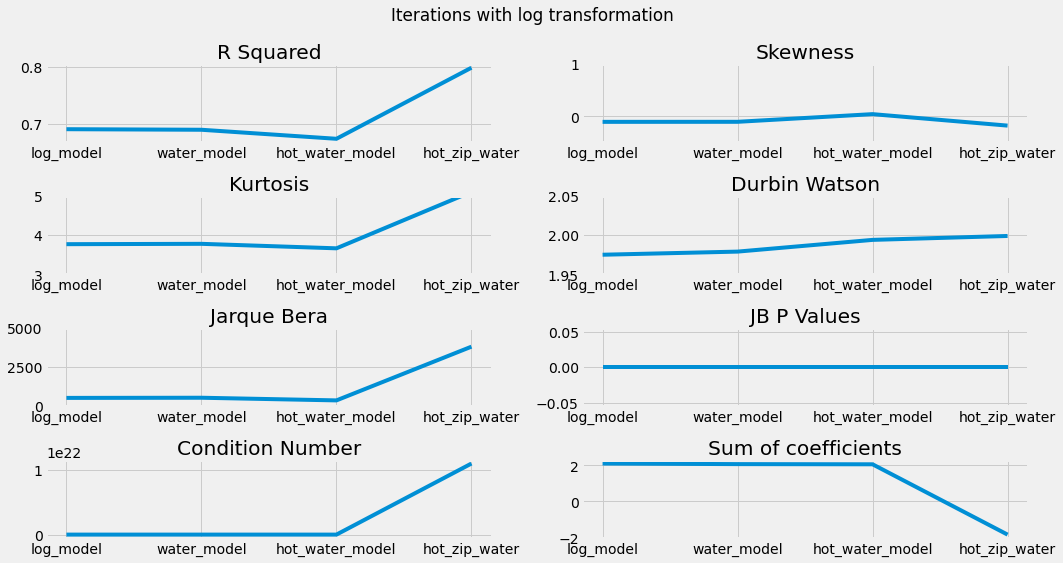

In [56]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared')
sk = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness')
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['kurtoses'],ax=axes[1,0]).set_title('Kurtosis')
axes[1,0].set_ylim(3,5)
db = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Durbin Watsons'],ax=axes[1,1]).set_title('Durbin Watson')
axes[1,1].set_ylim(1.95,2.05)
jb = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera')
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['P values'],ax=axes[2,1]).set_title('JB P Values')
cn = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number')
# axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=water_strengths_tick_list,y=water_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients')
# axes[3,1].set_ylim(1.5,3)

plt.gcf().set_size_inches(15, 8)
fig.suptitle('Iterations with log transformation')
fig.tight_layout()
plt.show()

The above visualization demonstrates that hot_water_model, the model including one-hot enocding waterfront locations but not the zipcodes themselves nor and tax info, is the most reliable model. 

### Exploring tax bracket and revenue by zipcode

In [57]:
X_taxes['income_tax_bracket'] = X_taxes.zipcode.replace(to_replace=joint_filing_tax_dict) # joint filing
X_taxes['zip_tax_revenue'] = X_taxes.zipcode.replace(to_replace=tax_revenue_dict)

# bracket_dummies = pd.get_dummies(X_taxes.income_tax_bracket,prefix='tax_bracket',prefix_sep='_',drop_first=True)
# X_taxes = X_taxes.drop('zipcode',axis=1)

In [58]:
tax_model = run_OLS_model(X_taxes,y_log)
tax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     4220.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:28:38   Log-Likelihood:                 1615.8
No. Observations:               19982   AIC:                            -3202.
Df Residuals:                   19967   BIC:                            -3083.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -177.3094     11.538    -15.368      0.000    -199.924    -154.695
grade                  0.1575      0.002     66.058      0.000       0.153       0.162
yr_built              -0.0028   7.92e-05    -35.705      0.000      -0.003      -0.003
lat                    0.9375      0.014     68.772      0.000       0.911       0.964
sqft_living15          0.0001   3.72e-06     31.737      0.000       0.000       0.000
bathrooms              0.1419      0.003     45.342      0.000       0.136       0.148
view                   0.0665      0.003     24.615      0.000       0.061       0.072
condition              0.0531      0.003     19.708      0.000       0.048       0.058
sale_date              0.0002    1.5e-05     11.759      0.000       0.000       0.000
waterfront             0.3337      0.033     10.118      0.000       0.269       0.398
zipcode                0.0002   3.52e-05      5.659      0.000       0.000       0.000
yr_renovated        3.138e-05   4.84e-06      6.489      0.000    2.19e-05    4.09e-05
sale_month            -0.0021      0.001     -3.975      0.000      -0.003      -0.001
income_tax_bracket     0.1709      0.004     44.867      0.000       0.163       0.178
zip_tax_revenue     8.063e-11   3.36e-12     24.021      0.000    7.41e-11    8.72e-11
==============================================================================
Omnibus:                      643.459   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1664.817
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                       4.397   Cond. No.                     9.20e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Trying one-hot encoding tax bracket

In [59]:
X_taxes = pd.concat([X_taxes,bracket_dummies],axis=1)
X_taxes = X_taxes.drop('zipcode',axis=1)

In [60]:
stepwise_selections = stepwise_selection(X_taxes,y_log,verbose=False)
X_taxes = X_taxes[stepwise_selections]

recursive_selections = run_RFECV(X_taxes,y_log)
X_taxes = X_taxes[recursive_selections]

In [61]:
hot_tax_model = run_OLS_model(X_taxes,y_log)

In [62]:
tax_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.747
Method:                 Least Squares   F-statistic:                     4220.
Date:                Sat, 16 Apr 2022   Prob (F-statistic):               0.00
Time:                        19:28:41   Log-Likelihood:                 1615.8
No. Observations:               19982   AIC:                            -3202.
Df Residuals:                   19967   BIC:                            -3083.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const               -177.3094     11.538    -15.368      0.000    -199.924    -154.695
grade                  0.1575      0.002     66.058      0.000       0.153       0.162
yr_built              -0.0028   7.92e-05    -35.705      0.000      -0.003      -0.003
lat                    0.9375      0.014     68.772      0.000       0.911       0.964
sqft_living15          0.0001   3.72e-06     31.737      0.000       0.000       0.000
bathrooms              0.1419      0.003     45.342      0.000       0.136       0.148
view                   0.0665      0.003     24.615      0.000       0.061       0.072
condition              0.0531      0.003     19.708      0.000       0.048       0.058
sale_date              0.0002    1.5e-05     11.759      0.000       0.000       0.000
waterfront             0.3337      0.033     10.118      0.000       0.269       0.398
zipcode                0.0002   3.52e-05      5.659      0.000       0.000       0.000
yr_renovated        3.138e-05   4.84e-06      6.489      0.000    2.19e-05    4.09e-05
sale_month            -0.0021      0.001     -3.975      0.000      -0.003      -0.001
income_tax_bracket     0.1709      0.004     44.867      0.000       0.163       0.178
zip_tax_revenue     8.063e-11   3.36e-12     24.021      0.000    7.41e-11    8.72e-11
==============================================================================
Omnibus:                      643.459   Durbin-Watson:                   1.982
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1664.817
Skew:                          -0.109   Prob(JB):                         0.00
Kurtosis:                       4.397   Cond. No.                     9.20e+12
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.2e+12. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

observations: including tax bracket or tax revenue data tends to weaken the model and is not worth including.

Will not consider including tax data, will validate hot_water_model using multiple train-test splits.

In [63]:
# create a train and a test split
X_train, X_test, y_train, y_test = train_test_split(X_hot_waters, y_log, test_size=0.2)

# generate predictions based on test and train sampels
linreg = LinearRegression()
linreg.fit(X_train, y_train)

y_hat_train = linreg.predict(X_train)
y_hat_test = linreg.predict(X_test)

# calculate train and test residuals
train_residuals = y_hat_train - y_train
test_residuals = y_hat_test - y_test

In [64]:
# calculate train and test mean squared error 
train_mse = mean_squared_error(y_train, y_hat_train)
test_mse = mean_squared_error(y_test, y_hat_test)

print('Train Mean Squarred Error:', round(train_mse,3))
print('Test Mean Squarred Error:', round(test_mse,3))
print('Difference: ', round(abs(train_mse - test_mse),3))

Train Mean Squarred Error: 0.04
Test Mean Squarred Error: 0.038
Difference:  0.001


In [65]:
cv_5_results  = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=5,  scoring='neg_mean_squared_error'))
cv_10_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=10, scoring='neg_mean_squared_error'))
cv_20_results = np.mean(cross_val_score(linreg, X_outliers, y_log, cv=20, scoring='neg_mean_squared_error'))

print('Five k-fold MSE: ', round(cv_5_results,3))
print('Ten k-fold MSE: ', round(cv_10_results,3))
print('Twenty k-fold MSE: ', round(cv_20_results,3))

Five k-fold MSE:  -0.049
Ten k-fold MSE:  -0.049
Twenty k-fold MSE:  -0.048


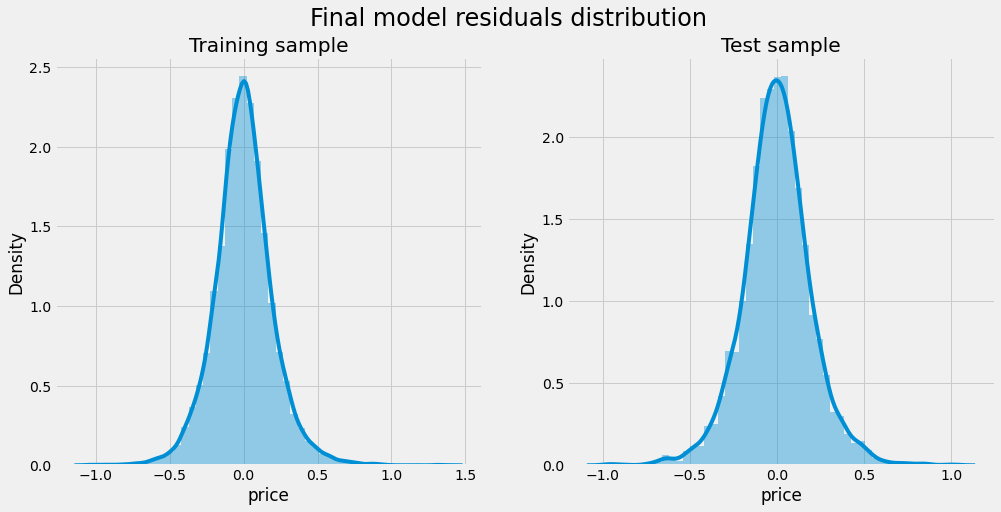

In [84]:
fig, (ax1,ax2) = plt.subplots(1,2)

sns.distplot(train_residuals,ax=ax1)
ax1.set_title('Training sample')
sns.distplot(test_residuals,ax=ax2)
ax2.set_title('Test sample')

fig.suptitle('Final model residuals distribution',fontsize=24)
plt.gcf().set_size_inches(15, 7)
plt.show()

The simple train-test split as well as usingthe k-fold technique show virtually no difference in the mean-squared error of the test and training samples, aslo the MSE itself is nearly zero but not exactly zero. This indicates that this model is appropriately fitted to the data used in this notebook and probably fits the analogous population data well also. I feel confident that this model is reliable and can be used with confidence to make decisions for the business.  

# Final Observations

After a robust and extensive iterative process the model name "hot_water_model" is the strongest and most reliable model found in throughout the exploratory process within this notebook. By sheer value the condition number and Jarque Bera are far from zero, which is normally interpreted as an indication that the data is not normally distributed. However, when compared to earlier iterations of the model the final condition number, Jarque Bera as well as other indicators of normality are nearly exactly where they should be when viewed *at scale*. Also, the distribution of the model residual visaully appear to be very normal. 

it became clear that some of the inferred features (waterfront locations, tax brackets, etc.) were weakening the model, grouping these features qualitatively and examining how each of the groups affected the model on their own, it was obvious that any tax data should not be included but waterfront locations (one-hot included) were definitely worth including in the final model.

Ultimately the final model is the result of eliminating outliers (where the target variable is greater than 3 standard deviations from its mean), log-transforming the target variable, and extrapolating waterfront locations based on zipcode and one-hot encoding that discovered cartegorical data. While selecting, ranking and eliminating features based on P value, variance inflation factors, and coeficient magnitude at each of these aformentioned iterations. 

In [76]:
final_strengths_list = [base_model_strength,outlier_model_strength,log_model_strength,water_model_strength,hot_water_strength]

final_strengths_dict = {
'r_squares':[float(strength['r_squared']) for strength in final_strengths_list],
'skews':[float(strength['skew']) for strength in final_strengths_list],
'kurtoses':[float(strength['kurtosis']) for strength in final_strengths_list],
'Durbin Watsons':[float(strength['Durbin Watson']) for strength in final_strengths_list],
'Jarque Beras':[float(strength['Jarque-Bera']) for strength in final_strengths_list],
'P values':[float(strength['P value']) for strength in final_strengths_list],
'Condition numbers':[int(strength['Condition']) for strength in final_strengths_list],
'Coef. weights':[float(strength['Coef. weight']) for strength in final_strengths_list]
}

final_strengths_tick_list = ['baseline','outlier\nelimination','target log\ntransformed','rigorous feature\nselection','one-hot\nencoding']

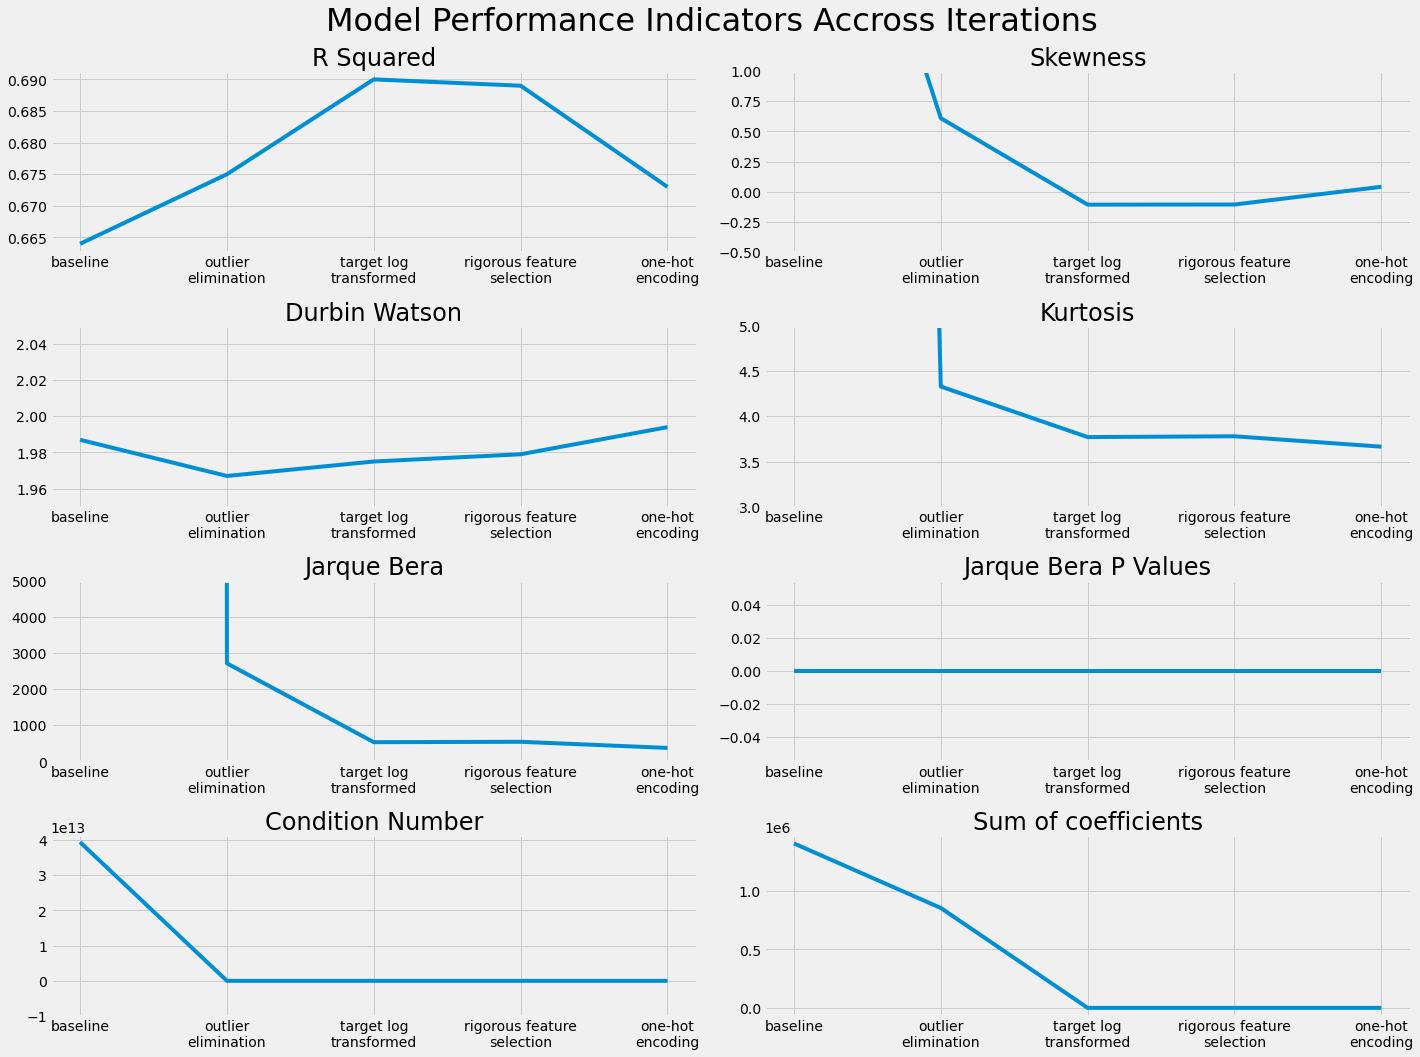

In [94]:
fig, axes = plt.subplots(4,2)

r_sq = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['r_squares'],ax=axes[0,0]).set_title('R Squared',fontsize=24)
sk = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['skews'],ax=axes[0,1]).set_title('Skewness',fontsize=24)
axes[0,1].set_ylim(-0.5,1)
kt = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['kurtoses'],ax=axes[1,1]).set_title('Kurtosis',fontsize=24)
axes[1,1].set_ylim(3,5)
db = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Durbin Watsons'],ax=axes[1,0]).set_title('Durbin Watson',fontsize=24)
axes[1,0].set_ylim(1.95,2.05)
jb = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Jarque Beras'],ax=axes[2,0]).set_title('Jarque Bera',fontsize=24)
axes[2,0].set_ylim(0,5000)
pv = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['P values'],ax=axes[2,1]).set_title('Jarque Bera P Values',fontsize=24)
cn = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Condition numbers'],ax=axes[3,0]).set_title('Condition Number',fontsize=24)
axes[3,0].set_ylim(-10000000000000)
cf = sns.lineplot(x=final_strengths_tick_list,y=final_strengths_dict['Coef. weights'],ax=axes[3,1]).set_title('Sum of coefficients',fontsize=24)


plt.gcf().set_size_inches(20, 15)
fig.suptitle('Model Performance Indicators Accross Iterations',fontsize=32)
fig.tight_layout()
plt.show()

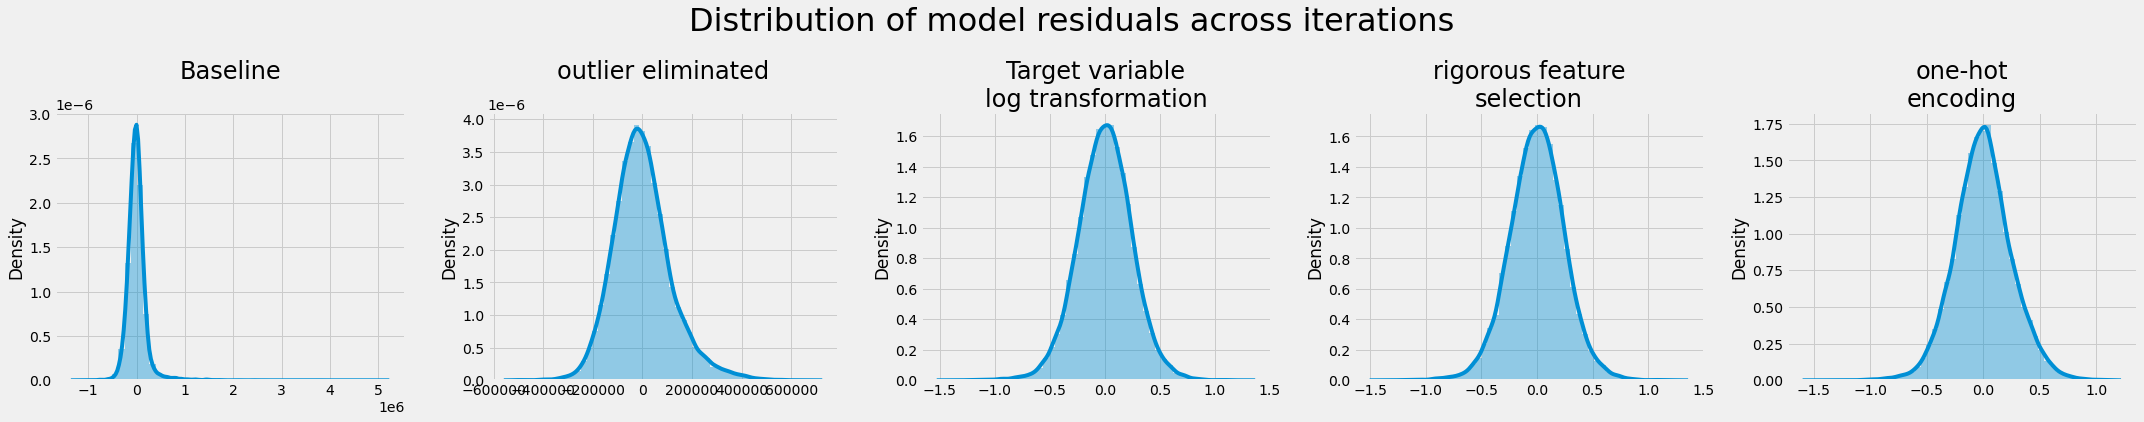

In [96]:
fig, (ax1,ax2,ax3,ax4,ax5) = plt.subplots(1,5)

bs = sns.distplot(base_resid,ax=ax1).set_title('Baseline\n',fontsize=24)
# axes[0,0].set_xlim(-1300000,1300000)

ot = sns.distplot(outlier_model_residual,ax=ax2).set_title('outlier eliminated\n',fontsize=24)

lm = sns.distplot(log_model_residuals,ax=ax3).set_title("Target variable\nlog transformation",fontsize=24)

bl = sns.distplot(water_model_residuals,ax=ax4).set_title('rigorous feature\nselection',fontsize=24)

lm = sns.distplot(hot_water_residuals,ax=ax5).set_title('one-hot\nencoding',fontsize=24)

plt.gcf().set_size_inches(30, 6)
fig.suptitle("Distribution of model residuals across iterations",fontsize=32)
fig.tight_layout()
plt.show()